In [ ]:
from lib.utils import load_raw_list
import pandas as pd
from tqdm import tqdm
import torch
import os

from torch import nn
from torch.nn.functional import relu,one_hot
from sklearn.model_selection import train_test_split
from lib.datasets import WindowedEEGDataset
from torch.utils.data import TensorDataset,DataLoader

device = 'cuda'

In [3]:
train_idx,dev_idx = train_test_split(range(len(os.listdir('windowed'))),test_size=.2,shuffle=True,random_state=0)

In [4]:
trainloader = DataLoader(WindowedEEGDataset(f'windowed',train_idx),batch_size=128,shuffle=True)
devloader = DataLoader(WindowedEEGDataset(f'windowed',dev_idx),batch_size=128,shuffle=True)

In [5]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(15000,128)
        self.fc2 = nn.Linear(128,3)
    def forward(self,x):
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        return x

In [6]:
model = MLP().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)

In [7]:
loss_tr = []
loss_dev = []

In [10]:
for i in tqdm(range(100)):
    model.train()
    loss_tr_total = 0
    for (X_tr,y_tr) in trainloader:
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_tr_total += loss.item()
    loss_tr.append(loss_tr_total/len(trainloader))
    model.eval()
    loss_dev_total = 0
    for (X_dv,y_dv) in devloader:
        X_dv,y_dv = X_dv.to(device),y_dv.to(device)
        logits = model(X_dv)
        loss = criterion(logits,y_dv)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_dev_total += loss.item()
    loss_dev.append(loss_dev_total/len(devloader))

 20%|██        | 20/100 [11:36<46:24, 34.81s/it]


KeyboardInterrupt: 

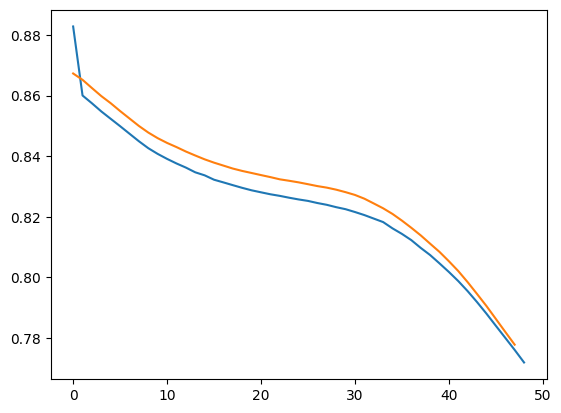

In [11]:
import matplotlib.pyplot as plt
plt.plot(loss_tr)
plt.plot(loss_dev)

<AxesSubplot:>

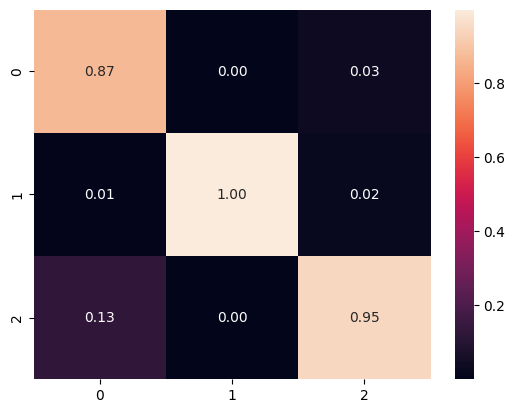

In [46]:
y_pred = torch.softmax(model(X_dev.to(device)),axis=1).argmax(axis=1).cpu()
y_true = y_dev.argmax(axis=1).cpu()
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='pred'),annot=True,fmt=".2f")